# Density Operator

In [2]:
"""Tests for DensityMatrix quantum state class."""

import unittest
import logging
import numpy as np
from numpy.testing import assert_allclose

from qiskit.test import QiskitTestCase
from qiskit import QiskitError
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import HGate

from qiskit.quantum_info.random import random_unitary
from qiskit.quantum_info.states import DensityMatrix, Statevector
from qiskit.quantum_info.operators.operator import Operator

logger = logging.getLogger(__name__)


class TestDensityMatrix(QiskitTestCase):
    """Tests for DensityMatrix class."""

    @classmethod
    def rand_vec(cls, n, normalize=False):
        """Return complex vector or statevector"""
        seed = np.random.randint(0, np.iinfo(np.int32).max)
        logger.debug("rand_vec default_rng seeded with seed=%s", seed)
        rng = np.random.default_rng(seed)
        vec = rng.random(n) + 1j * rng.random(n)
        if normalize:
            vec /= np.sqrt(np.dot(vec, np.conj(vec)))
        return vec

    @classmethod
    def rand_rho(cls, n):
        """Return random pure state density matrix"""
        rho = cls.rand_vec(n, normalize=True)
        return np.outer(rho, np.conjugate(rho))





   



    def test_sample_counts_qutrit(self):
        """Test sample_counts method for qutrit state"""
        p = 0.3
        shots = 1000
        threshold = 0.03 * shots
        state = DensityMatrix(np.diag([p, 0, 1 - p]))
        state.seed(100)

        with self.subTest(msg='counts'):
            target = {'0': shots * p, '2': shots * (1 - p)}
            counts = state.sample_counts(shots=shots)
            self.assertDictAlmostEqual(counts, target, threshold)

    def test_sample_memory_ghz(self):
        """Test sample_memory method for GHZ state"""

        shots = 2000
        state = DensityMatrix((
            Statevector.from_label('000') +
            Statevector.from_label('111')) / np.sqrt(2))
        state.seed(100)

        # 3-qubit qargs
        target = {'000': shots / 2, '111': shots / 2}
        for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

        # 2-qubit qargs
        target = {'00': shots / 2, '11': shots / 2}
        for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

        # 1-qubit qargs
        target = {'0': shots / 2, '1': shots / 2}
        for qargs in [[0], [1], [2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

    def test_sample_memory_w(self):
        """Test sample_memory method for W state"""
        shots = 3000
        state = DensityMatrix((
            Statevector.from_label('001') +
            Statevector.from_label('010') +
            Statevector.from_label('100')) / np.sqrt(3))
        state.seed(100)

        target = {'001': shots / 3, '010': shots / 3, '100': shots / 3}
        for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

        # 2-qubit qargs
        target = {'00': shots / 3, '01': shots / 3, '10': shots / 3}
        for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

        # 1-qubit qargs
        target = {'0': 2 * shots / 3, '1': shots / 3}
        for qargs in [[0], [1], [2]]:

            with self.subTest(msg='memory (qargs={})'.format(qargs)):
                memory = state.sample_memory(shots, qargs=qargs)
                self.assertEqual(len(memory), shots)
                self.assertEqual(set(memory), set(target))

    def test_sample_memory_qutrit(self):
        """Test sample_memory method for qutrit state"""
        p = 0.3
        shots = 1000
        state = DensityMatrix(np.diag([p, 0, 1 - p]))
        state.seed(100)

        with self.subTest(msg='memory'):
            memory = state.sample_memory(shots)
            self.assertEqual(len(memory), shots)
            self.assertEqual(set(memory), set(['0', '2']))

    def test_reset_2qubit(self):
        """Test reset method for 2-qubit state"""

        state = DensityMatrix(np.diag([0.5, 0, 0, 0.5]))

        with self.subTest(msg='reset'):
            rho = state.copy()
            value = rho.reset()
            target = DensityMatrix(np.diag([1, 0, 0, 0]))
            self.assertEqual(value, target)

        with self.subTest(msg='reset'):
            rho = state.copy()
            value = rho.reset([0, 1])
            target = DensityMatrix(np.diag([1, 0, 0, 0]))
            self.assertEqual(value, target)

        with self.subTest(msg='reset [0]'):
            rho = state.copy()
            value = rho.reset([0])
            target = DensityMatrix(np.diag([0.5, 0, 0.5, 0]))
            self.assertEqual(value, target)

        with self.subTest(msg='reset [0]'):
            rho = state.copy()
            value = rho.reset([1])
            target = DensityMatrix(np.diag([0.5, 0.5, 0, 0]))
            self.assertEqual(value, target)

    def test_reset_qutrit(self):
        """Test reset method for qutrit"""

        state = DensityMatrix(np.diag([1, 1, 1]) / 3)
        state.seed(200)
        value = state.reset()
        target = DensityMatrix(np.diag([1, 0, 0]))
        self.assertEqual(value, target)

    def test_measure_2qubit(self):
        """Test measure method for 2-qubit state"""

        state = DensityMatrix.from_label('+0')
        seed = 200
        shots = 100

        with self.subTest(msg='measure'):
            for i in range(shots):
                rho = state.copy()
                rho.seed(seed + i)
                outcome, value = rho.measure()
                self.assertIn(outcome, ['00', '10'])
                if outcome == '00':
                    target = DensityMatrix.from_label('00')
                    self.assertEqual(value, target)
                else:
                    target = DensityMatrix.from_label('10')
                    self.assertEqual(value, target)

        with self.subTest(msg='measure [0, 1]'):
            for i in range(shots):
                rho = state.copy()
                outcome, value = rho.measure([0, 1])
                self.assertIn(outcome, ['00', '10'])
                if outcome == '00':
                    target = DensityMatrix.from_label('00')
                    self.assertEqual(value, target)
                else:
                    target = DensityMatrix.from_label('10')
                    self.assertEqual(value, target)

        with self.subTest(msg='measure [1, 0]'):
            for i in range(shots):
                rho = state.copy()
                outcome, value = rho.measure([1, 0])
                self.assertIn(outcome, ['00', '01'])
                if outcome == '00':
                    target = DensityMatrix.from_label('00')
                    self.assertEqual(value, target)
                else:
                    target = DensityMatrix.from_label('10')
                    self.assertEqual(value, target)
        with self.subTest(msg='measure [0]'):
            for i in range(shots):
                rho = state.copy()
                outcome, value = rho.measure([0])
                self.assertEqual(outcome, '0')
                target = DensityMatrix.from_label('+0')
                self.assertEqual(value, target)

        with self.subTest(msg='measure [1]'):
            for i in range(shots):
                rho = state.copy()
                outcome, value = rho.measure([1])
                self.assertIn(outcome, ['0', '1'])
                if outcome == '0':
                    target = DensityMatrix.from_label('00')
                    self.assertEqual(value, target)
                else:
                    target = DensityMatrix.from_label('10')
                    self.assertEqual(value, target)

    def test_measure_qutrit(self):
        """Test measure method for qutrit"""

        state = DensityMatrix(np.diag([1, 1, 1]) / 3)
        seed = 200
        shots = 100

        for i in range(shots):
            rho = state.copy()
            rho.seed(seed + i)
            outcome, value = rho.measure()
            self.assertIn(outcome, ['0', '1', '2'])
            if outcome == '0':
                target = DensityMatrix(np.diag([1, 0, 0]))
                self.assertEqual(value, target)
            elif outcome == '1':
                target = DensityMatrix(np.diag([0, 1, 0]))
                self.assertEqual(value, target)
            else:
                target = DensityMatrix(np.diag([0, 0, 1]))
                self.assertEqual(value, target)

    def test_from_int(self):
        """Test from_int method"""

        with self.subTest(msg='from_int(0, 4)'):
            target = DensityMatrix([1, 0, 0, 0])
            value = DensityMatrix.from_int(0, 4)
            self.assertEqual(target, value)

        with self.subTest(msg='from_int(3, 4)'):
            target = DensityMatrix([0, 0, 0, 1])
            value = DensityMatrix.from_int(3, 4)
            self.assertEqual(target, value)

        with self.subTest(msg='from_int(8, (3, 3))'):
            target = DensityMatrix([0, 0, 0, 0, 0, 0, 0, 0, 1], dims=(3, 3))
            value = DensityMatrix.from_int(8, (3, 3))
            self.assertEqual(target, value)

In [42]:
def get_random_density_operator(n):
    # complex vector or statevector
    seed = np.random.randint(0, np.iinfo(np.int32).max)
    logger.debug("rand_vec default_rng seeded with seed=%s", seed)
    rng = np.random.default_rng(seed)
    psi = rng.random(n) + 1j * rng.random(n)
    # Normalize
    psi /= np.sqrt(np.dot(psi, np.conj(psi)))

    # random pure state density matrix
    return (np.outer(psi, np.conjugate(psi)))

# initialization from array
rho = get_random_density_operator(3)
print(rho)
# Create DensityMatrix
state = DensityMatrix(rho)
# Properties of a Density Matrix
print(state.data)
print('total state dimension : ',state.dim)
print('tuple of input dimension for specified subsystems : ',state.dims())
print('number of qubits if a N-qubit state : ',state.num_qubits)

[[0.33679343+0.j         0.26823991+0.06549898j 0.26243789+0.27972702j]
 [0.26823991-0.06549898j 0.22637842+0.j         0.26342007+0.17175079j]
 [0.26243789-0.27972702j 0.26342007-0.17175079j 0.43682816+0.j        ]]
[[0.33679343+0.j         0.26823991+0.06549898j 0.26243789+0.27972702j]
 [0.26823991-0.06549898j 0.22637842+0.j         0.26342007+0.17175079j]
 [0.26243789-0.27972702j 0.26342007-0.17175079j 0.43682816+0.j        ]]
total state dimension :  3
tuple of input dimension for specified subsystems :  (3,)
number of qubits if a N-qubit state :  None


In [39]:
rho = get_random_density_operator(2 * 3 * 4)
state = DensityMatrix(rho, dims=[2, 3, 4])
print(state.data)
#print(rho)
print(state.dim, state.dims(),state.num_qubits)

[[0.03997151+0.j         0.02247384+0.03998379j 0.05549658+0.01880803j
  0.02904286+0.02315477j 0.01837818+0.04079191j 0.01695893+0.03213783j
  0.0368192 +0.00051635j 0.02757563+0.03027465j 0.02249149+0.0375764j
  0.0263605 -0.00744055j 0.02844816+0.00856897j 0.01258358+0.00336552j
  0.05056514+0.00487476j 0.03211058-0.00593447j 0.03946973+0.02998035j
  0.04276387+0.0309114j  0.042175  +0.02661502j 0.04112696-0.00801156j
  0.02346026-0.0035793j  0.00853885+0.00977146j 0.02366835+0.01638645j
  0.03099769+0.03469069j 0.0459198 +0.00179368j 0.04380624+0.02225376j]
 [0.02247384-0.03998379j 0.0526319 +0.j         0.05001655-0.04493888j
  0.03949112-0.01603309j 0.05113751+0.00455128j 0.04168279+0.00110524j
  0.02121797-0.03654019j 0.04578825-0.01056229j 0.05023369-0.0013712j
  0.00737826-0.03055202j 0.02456648-0.02363902j 0.01044163-0.0106952j
  0.03330633-0.04783985j 0.01211777-0.03545707j 0.05218127-0.02262551j
  0.05496472-0.02539718j 0.05033594-0.02722375j 0.01510946-0.04564406j
  0.0096

In [40]:
# Test initialization from a circuit
# random unitaries
u0 = random_unitary(2).data
u1 = random_unitary(2).data
# add to circuit
qr = QuantumRegister(2)
circ = QuantumCircuit(qr)
circ.unitary(u0, [qr[0]])
circ.unitary(u1, [qr[1]])
target_vec = Statevector(np.kron(u1, u0).dot([1, 0, 0, 0]))
target = DensityMatrix(target_vec)
# we retrieve the density matrix of an instruction
rho = DensityMatrix.from_instruction(circ)
print(rho)
print(target)

DensityMatrix([[ 0.52553912+0.j        , -0.02504245+0.21062109j,
                -0.09143598+0.40911339j, -0.15960397-0.05613958j],
               [-0.02504245-0.21062109j,  0.08560422+0.j        ,
                 0.16831799+0.01715029j, -0.01489386+0.06663982j],
               [-0.09143598-0.40911339j,  0.16831799-0.01715029j,
                 0.33438863+0.j        , -0.01593394+0.13401342j],
               [-0.15960397+0.05613958j, -0.01489386-0.06663982j,
                -0.01593394-0.13401342j,  0.05446803+0.j        ]],
              dims=(2, 2))
DensityMatrix([[ 0.52553912+0.j        , -0.02504245+0.21062109j,
                -0.09143598+0.40911339j, -0.15960397-0.05613958j],
               [-0.02504245-0.21062109j,  0.08560422+0.j        ,
                 0.16831799+0.01715029j, -0.01489386+0.06663982j],
               [-0.09143598-0.40911339j,  0.16831799-0.01715029j,
                 0.33438863+0.j        , -0.01593394+0.13401342j],
               [-0.15960397+0.05613958j, 

In [7]:
# Test tensor product of 1-qubit gates
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.x(1)
circuit.ry(np.pi / 2, 2)
target = DensityMatrix.from_label('000').evolve(Operator(circuit))
rho = DensityMatrix.from_instruction(circuit)
print(rho)
print(target)

DensityMatrix([[0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
                0.  +0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
                0.  +0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j,
                0.  +0.j, 0.25+0.j, 0.25+0.j],
               [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j,
                0.  +0.j, 0.25+0.j, 0.25+0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
                0.  +0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
                0.  +0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j,
                0.  +0.j, 0.25+0.j, 0.25+0.j],
               [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j,
                0.  +0.j, 0.25+0.j, 0.25+0.j]],
              dims=(2, 2, 2))
DensityMatrix([[0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,

In [8]:
# Test decomposition of controlled-H gate
circuit = QuantumCircuit(2)
circ.x(0)
circuit.ch(0, 1)
target = DensityMatrix.from_label('00').evolve(Operator(circuit))
rho = DensityMatrix.from_instruction(circuit)
print(rho)
print(target)

DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))
DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))


In [9]:
# Test initialize instruction
init = Statevector([1, 0, 0, 1j]) / np.sqrt(2)
target = DensityMatrix(init)
circuit = QuantumCircuit(2)
circuit.initialize(init.data, [0, 1])
rho = DensityMatrix.from_instruction(circuit)
print(rho)
print(target)

DensityMatrix([[0.5+0.j , 0. +0.j , 0. +0.j , 0. -0.5j],
               [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
               [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
               [0. +0.5j, 0. +0.j , 0. +0.j , 0.5+0.j ]],
              dims=(2, 2))
DensityMatrix([[0.5+0.j , 0. +0.j , 0. +0.j , 0. -0.5j],
               [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
               [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
               [0. +0.5j, 0. +0.j , 0. +0.j , 0.5+0.j ]],
              dims=(2, 2))


In [10]:
# initialization from an instruction
target_vec = Statevector(np.dot(HGate().to_matrix(), [1, 0]))
target = DensityMatrix(target_vec)
rho = DensityMatrix.from_instruction(HGate())
print(rho)
print(target)

DensityMatrix([[0.5+0.j, 0.5+0.j],
               [0.5+0.j, 0.5+0.j]],
              dims=(2,))
DensityMatrix([[0.5+0.j, 0.5+0.j],
               [0.5+0.j, 0.5+0.j]],
              dims=(2,))


In [41]:
# initialization from a label - Returns a tensor product of Pauli X,Y,Z eigenstates
x_p = DensityMatrix(np.array([[0.5, 0.5], [0.5, 0.5]]))
x_m = DensityMatrix(np.array([[0.5, -0.5], [-0.5, 0.5]]))
y_p = DensityMatrix(np.array([[0.5, -0.5j], [0.5j, 0.5]]))
y_m = DensityMatrix(np.array([[0.5, 0.5j], [-0.5j, 0.5]]))
z_p = DensityMatrix(np.diag([1, 0]))
z_m = DensityMatrix(np.diag([0, 1]))

label = '0+r'
target = z_p.tensor(x_p).tensor(y_p)
print(DensityMatrix.from_label(label))
print(target)

DensityMatrix([[0.25+0.j  , 0.  -0.25j, 0.25+0.j  , 0.  -0.25j,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.25j, 0.25+0.j  , 0.  +0.25j, 0.25+0.j  ,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.25+0.j  , 0.  -0.25j, 0.25+0.j  , 0.  -0.25j,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.25j, 0.25+0.j  , 0.  +0.25j, 0.25+0.j  ,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ,
                0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
               [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ,
                0.  +0.j  , 0.  +

In [13]:
label = '-l1'
target = x_m.tensor(y_m).tensor(z_m)
print(DensityMatrix.from_label(label))
print(target)

DensityMatrix([[ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
                 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ],
               [ 0.  +0.j  ,  0.25+0.j  ,  0.  +0.j  ,  0.  +0.25j,
                 0.  +0.j  , -0.25-0.j  ,  0.  +0.j  ,  0.  -0.25j],
               [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
                 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ],
               [ 0.  -0.j  ,  0.  -0.25j,  0.  -0.j  ,  0.25+0.j  ,
                 0.  -0.j  , -0.  +0.25j,  0.  -0.j  , -0.25-0.j  ],
               [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
                 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ],
               [ 0.  +0.j  , -0.25+0.j  ,  0.  +0.j  , -0.  -0.25j,
                 0.  +0.j  ,  0.25+0.j  ,  0.  +0.j  ,  0.  +0.25j],
               [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
                 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ],
               [ 0.  +0.j  ,  0.  +0.25j,

In [29]:
# DensityMatrix copy method - Make a copy of current operator
rho = get_random_density_operator(4)
orig = DensityMatrix(rho)
cpy = orig.copy()
cpy._data[0] += 1.0
print(cpy == orig)

False


In [30]:
# DensityOperator is_valid method
# DensityMatrix.is_valid([atol, rtol]) - Return True if trace 1 and positive semidefinite.
state = DensityMatrix(np.eye(2))
print(state.is_valid())
for _ in range(4):
    state = DensityMatrix(get_random_density_operator(4))
    print(state.is_valid())

False
True
True
True
True


In [31]:
#DensityMatrix to_operator method for returning projector - Convert to Operator
rho = get_random_density_operator(4)
target = Operator(rho)
op = DensityMatrix(rho).to_operator()
print(op == target)

True


In [32]:
# evolve method for operators - Evolve a quantum state by an operator.
op = random_unitary(4)
rho = get_random_density_operator(4)
target = DensityMatrix(np.dot(op.data, rho).dot(op.adjoint().data))
evolved = DensityMatrix(rho).evolve(op)
print(target==evolved)

True


In [33]:
# conjugate method - Return the conjugate of the density matrix.
rho = get_random_density_operator(4)
target = DensityMatrix(np.conj(rho))
state = DensityMatrix(rho).conjugate()
print(state==target)

True


In [34]:
# expand method - Return the tensor product state other ⊗ self.
rho0 = get_random_density_operator(2)
rho1 = get_random_density_operator(3)
target = np.kron(rho1, rho0)
state = DensityMatrix(rho0).expand(DensityMatrix(rho1))
print(state.dim,state.dims())
print(state.data)
print(target)

6 (2, 3)
[[0.343569  +0.j         0.17148537+0.05246228j 0.14302464+0.32697878j
  0.02145881+0.18504427j 0.15144226+0.04075534j 0.06936602+0.0434671j ]
 [0.17148537-0.05246228j 0.09360426+0.j         0.12131678+0.14136514j
  0.0389666 +0.08908431j 0.08181253-0.00278274j 0.04125996+0.01110366j]
 [0.14302464-0.32697878j 0.12131678-0.14136514j 0.3707295 +0.j
  0.18504198+0.05660963j 0.10183138-0.12716336j 0.07024461-0.04792152j]
 [0.02145881-0.18504427j 0.0389666 -0.08908431j 0.18504198-0.05660963j
  0.10100406+0.j         0.03140945-0.07902041j 0.02774363-0.03464525j]
 [0.15144226-0.04075534j 0.08181253+0.00278274j 0.10183138+0.12716336j
  0.03140945+0.07902041j 0.07158899+0.j         0.03573216+0.01093149j]
 [0.06936602-0.0434671j  0.04125996-0.01110366j 0.07024461+0.04792152j
  0.02774363+0.03464525j 0.03573216-0.01093149j 0.01950419+0.j        ]]
[[0.343569  +0.j         0.17148537+0.05246228j 0.14302464+0.32697878j
  0.02145881+0.18504427j 0.15144226+0.04075534j 0.06936602+0.0434671j

In [35]:
# tensor method - Return the tensor product state self ⊗ other.
rho0 = get_random_density_operator(2)
rho1 = get_random_density_operator(3)
target = np.kron(rho0, rho1)
state = DensityMatrix(rho0).tensor(DensityMatrix(rho1))
print(state.dim,state.dims())
print(state.data)

6 (3, 2)
[[ 0.15232389+0.j          0.0674712 -0.03852165j  0.05702681-0.08462037j
   0.16337792-0.19808907j  0.02227219-0.12905981j -0.04887906-0.16492152j]
 [ 0.0674712 +0.03852165j  0.03962792+0.j          0.04665967-0.02306054j
   0.12246287-0.04642555j  0.04250369-0.05153399j  0.02005673-0.08541243j]
 [ 0.05702681+0.08462037j  0.04665967+0.02306054j  0.06835871+0.j
   0.17120947+0.01660089j  0.08003473-0.03594438j  0.07331945-0.08889684j]
 [ 0.16337792+0.19808907j  0.12246287+0.04642555j  0.17120947-0.01660089j
   0.43283836+0.j          0.19172384-0.10946179j  0.16204543-0.24045435j]
 [ 0.02227219+0.12905981j  0.04250369+0.05153399j  0.08003473+0.03594438j
   0.19172384+0.10946179j  0.11260535+0.j          0.13258653-0.06552804j]
 [-0.04887906+0.16492152j  0.02005673+0.08541243j  0.07331945+0.08889684j
   0.16204543+0.24045435j  0.13258653+0.06552804j  0.19424576+0.j        ]]


In [36]:
# add method - Return the linear combination self + other.
rho0 = get_random_density_operator(4)
rho1 = get_random_density_operator(4)
state0 = DensityMatrix(rho0)
state1 = DensityMatrix(rho1)
print(state0 + state1 == DensityMatrix(rho0 + rho1))

# subtract method - Return the linear operator self - other.
#rho0 = get_random_density_operator(4)
#rho1 = get_random_density_operator(4)
#state0 = DensityMatrix(rho0)
#state1 = DensityMatrix(rho1)
print(state0 - state1==DensityMatrix(rho0 - rho1))

True
True


In [23]:












    








DensityMatrix.from_int(i, dims)
	

Return a computational basis state density matrix.



DensityMatrix.measure([qargs])
	

Measure subsystems and return outcome and post-measure state.


DensityMatrix.probabilities([qargs, decimals])
	

Return the subsystem measurement probability vector.

DensityMatrix.probabilities_dict([qargs, …])
	

Return the subsystem measurement probability dictionary.

DensityMatrix.purity()
	

Return the purity of the quantum state.

DensityMatrix.reset([qargs])
	

Reset state or subsystems to the 0-state.

DensityMatrix.sample_counts(shots[, qargs])
	

Sample a dict of qubit measurement outcomes in the computational basis.

DensityMatrix.sample_memory(shots[, qargs])
	

Sample a list of qubit measurement outcomes in the computational basis.

DensityMatrix.seed([value])
	

Set the seed for the quantum state RNG.

DensityMatrix.set_atol(value)
	

Set the class default absolute tolerance parameter for float comparisons.

DensityMatrix.set_rtol(value)
	

Set the class default relative tolerance parameter for float comparisons.


DensityMatrix.to_counts()
	

Returns the density matrix as a counts dict of probabilities.


DensityMatrix.trace()
	

Return the trace of the density matrix.    
            
                

True


In [37]:
# multiply method - Return the scalar multipled state other * self.
rho = get_random_density_operator(4)
state = DensityMatrix(rho)
val = np.random.rand() + 1j * np.random.rand()
print(val * state==DensityMatrix(val * state))

# Negation
rho = get_random_density_operator(4)
state = DensityMatrix(rho)
print(-state==DensityMatrix(-1 * rho))

True


True


In [38]:
# to_dict method - Convert the density matrix to dictionary form
rho = DensityMatrix(np.arange(1, 17).reshape(4, 4))
print(rho.to_dict())

rho = DensityMatrix(np.diag(np.arange(1, 7)), dims=(2, 3))
print(rho.to_dict())

rho = DensityMatrix(np.diag(np.arange(1, 23)), dims=(2, 11))
print(rho.to_dict())

{'00|00': (1+0j), '01|00': (2+0j), '10|00': (3+0j), '11|00': (4+0j), '00|01': (5+0j), '01|01': (6+0j), '10|01': (7+0j), '11|01': (8+0j), '00|10': (9+0j), '01|10': (10+0j), '10|10': (11+0j), '11|10': (12+0j), '00|11': (13+0j), '01|11': (14+0j), '10|11': (15+0j), '11|11': (16+0j)}
{'00|00': (1+0j), '01|01': (2+0j), '10|10': (3+0j), '11|11': (4+0j), '20|20': (5+0j), '21|21': (6+0j)}
{'0,0|0,0': (1+0j), '0,1|0,1': (2+0j), '1,0|1,0': (3+0j), '1,1|1,1': (4+0j), '2,0|2,0': (5+0j), '2,1|2,1': (6+0j), '3,0|3,0': (7+0j), '3,1|3,1': (8+0j), '4,0|4,0': (9+0j), '4,1|4,1': (10+0j), '5,0|5,0': (11+0j), '5,1|5,1': (12+0j), '6,0|6,0': (13+0j), '6,1|6,1': (14+0j), '7,0|7,0': (15+0j), '7,1|7,1': (16+0j), '8,0|8,0': (17+0j), '8,1|8,1': (18+0j), '9,0|9,0': (19+0j), '9,1|9,1': (20+0j), '10,0|10,0': (21+0j), '10,1|10,1': (22+0j)}


In [43]:
# subsystem evolution for operators

# Test evolving single-qubit of 3-qubit system
rho = get_random_density_operator(8)
state = DensityMatrix(rho)
op0 = random_unitary(2)
op1 = random_unitary(2)
op2 = random_unitary(2)

# Evolve on 1-qubit
op = op0
op_full = Operator(np.eye(4)).tensor(op)
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[0])==target)

# Evolve on qubit 1
op_full = Operator(np.eye(2)).tensor(op).tensor(np.eye(2))
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[1])==target)

# Evolve on qubit 2
op_full = op.tensor(np.eye(4))
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[2])==target)

# Test evolve on 2-qubits
op = op1.tensor(op0)

# Evolve on qubits [0, 2]
op_full = op1.tensor(np.eye(2)).tensor(op0)
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[0, 2])== target)

# Evolve on qubits [2, 0]
op_full = op0.tensor(np.eye(2)).tensor(op1)
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[2, 0])==target)

# Test evolve on 3-qubits
op = op2.tensor(op1).tensor(op0)

# Evolve on qubits [0, 1, 2]
op_full = op
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[0, 1, 2])==target)

# Evolve on qubits [2, 1, 0]
op_full = op0.tensor(op1).tensor(op2)
target = DensityMatrix(np.dot(op_full.data, rho).dot(op_full.adjoint().data))
print(state.evolve(op, qargs=[2, 1, 0])==target)

True
True
True
True
True
True
True


In [44]:
# Convert a pure density matrix to statevector
state = 1/np.sqrt(2) * (np.array([1, 0, 0, 0, 0, 0, 0, 1]))
psi = Statevector(state)
rho = DensityMatrix(psi)
phi = rho.to_statevector()
print(psi.equiv(phi))


# Convert a pure density matrix to statevector
state_1 = 1/np.sqrt(2) * (np.array([1, 0, 0, 0, 0, 0, 0, 1]))
state_2 = 1/np.sqrt(2) * (np.array([0, 0, 0, 0, 0, 0, 1, 1]))
psi = 0.5 * (Statevector(state_1) + Statevector(state_2))
rho = DensityMatrix(psi)
#self.assertRaises(QiskitError, rho.to_statevector)
print(rho.to_statevector)

AttributeError: 'DensityMatrix' object has no attribute 'to_statevector'

In [45]:
# probabilities
state = DensityMatrix.from_label('+0')

# 2-qubit qargs
probs = state.probabilities()
print(probs)

probs = state.probabilities([0, 1])
print(probs)

probs = state.probabilities([1, 0])
print(probs)

# 1-qubit qargs
probs = state.probabilities([0])
print(probs)

probs = state.probabilities([1])
print(probs)

[0.5 0.  0.5 0. ]
[0.5 0.  0.5 0. ]
[0.5 0.5 0.  0. ]
[1. 0.]
[0.5 0.5]


### Problem 1

Let's say Alice wants to send Bob a $|0\rangle$ with probability *.5* and $|1\rangle$ also with probability *.5*. Alice prepares such a qubit in her lab. Then Alice sends this qubit to Bob - the system could be represented by the following density matrix: $$\rho = .5 |0\rangle \langle 0| + .5 |1\rangle \langle 1|= \begin{bmatrix} .5 & 0 \\ 0 & .5 \end{bmatrix}$$

Now, Bob would perform measurement in the standard basis. So, he could get $|0\rangle$ with probability .5 and $|1\rangle$ with .5. Then what is the density matrix representing the state after Bob performs his measurement in the standard basis accounting for both of his possible outcomes? 

### Solution 1

Bob is provided with the following state (also called the *maximally-mixed state*):

$\rho = \frac{1}{2}|0\rangle\langle 0| + \frac{1}{2}|1\rangle\langle 1| = \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix}$

From the expression we see that the density matrices enable us to capture the uncertainty of an outcome of a measurement. They also account for the different possible outcomes in a single equation. 

Projective measurement is defined by a set of measurement operators $P_i$, one for each possible measurement outcome. For example, when measuring in the computational basis (collapsing to $|0\rangle$ or $|1\rangle$) we have the following measurement operators:

$P_0 = |0\rangle\langle0| = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}$ - $P_0$ is associated with outcome $|0\rangle$ and $P_1 = |1\rangle\langle1| = \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}$ - $P_1$ is associated with outcome $|1\rangle$

These matrices are also called *projectors*.

Now, given a single-qbit density operator $\rho$, we can calculate the probability of it collapsing to some value with the following formula:

$p_i = Tr(P_i \rho)$ - [$Tr(M)$ is *trace* - sum of the elements along the main diagonal of matrix $M$]

Now we can calculate the probability of the above example collapsing to $|0\rangle$ as follows:

$p_0 = Tr(P_0 \rho)
= Tr \left( \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix} \right)
= Tr \left( \begin{bmatrix} \frac 1 2 & 0 \\ 0 & 0 \end{bmatrix} \right) = \frac 1 2$

And the formula for the post-measurement density operator is:

$\rho_i = \frac{P_i \rho P_i}{p_i}$

which for the above problem and for $|0\rangle$ is:

$\rho_0 = \frac{\begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}}{\frac 1 2} = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}$

which is indeed the density matrix for the pure state $|0\rangle$.

Now we do not just want the density operator for a certain measurement outcome, though. We actually seek a density operator that captures the branching nature of measurement, representing it as an ensemble of possible collapsed states. For this, we use the following formula:

$\rho' = \sum_i p_i \rho_i = \sum_i P_i \rho P_i$

in our example:

$\rho' = \left( \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \right) + \left( \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \right)$

$\rho' = \begin{bmatrix} \frac 1 2 & 0 \\ 0 & 0 \end{bmatrix}
+ \begin{bmatrix} 0 & 0 \\ 0 & \frac 1 2 \end{bmatrix} = \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & \frac{1}{2} \end{bmatrix} = \frac{1}{2}|0\rangle\langle 0| + \frac{1}{2}|1\rangle\langle 1|$

Hence we clearly see that the final density matrix remains unchanged! This is not really surprising, because we started  with the maximally-mixed state and then performed a further randomizing operation on it.

*Ref : [StackExchange 1](https://physics.stackexchange.com/a/426519/182854), [StackExchange 2](https://quantumcomputing.stackexchange.com/a/4130/4153).*

<img src="images/ha.png" alt="" width="500" align="middle"/>

The two bits we want to add are encoded in the qubits 0 and 1. The above example encodes a ```1``` in both these qubits, and so it seeks to find the solution of ```1+1```. The result will be a string of two bits, which we will read out from the qubits 2 and 3. All that remains is to fill in the actual program, which lives in the blank space in the middle.

In a quantum computer, an XOR gate is implemented by a controlled-NOT (CNOT) gate.

In [46]:
# probabilities for GHZ state
psi = (Statevector.from_label('000') +
       Statevector.from_label('111')) / np.sqrt(2)
state = DensityMatrix(psi)

# 3-qubit qargs
for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)

# 2-qubit qargs
for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)

# 1-qubit qargs
for qargs in [[0], [1], [2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)

P([0, 1, 2]) [0.5 0.  0.  0.  0.  0.  0.  0.5]
P([2, 1, 0]) [0.5 0.  0.  0.  0.  0.  0.  0.5]
P([1, 2, 0]) [0.5 0.  0.  0.  0.  0.  0.  0.5]
P([1, 0, 2]) [0.5 0.  0.  0.  0.  0.  0.  0.5]
P([0, 1]) [0.5 0.  0.  0.5]
P([2, 1]) [0.5 0.  0.  0.5]
P([1, 2]) [0.5 0.  0.  0.5]
P([1, 2]) [0.5 0.  0.  0.5]
P([0]) [0.5 0.5]
P([1]) [0.5 0.5]
P([2]) [0.5 0.5]


In [48]:
# sample_counts method for GHZ state
shots = 2000
threshold = 0.02 * shots
state = DensityMatrix((
    Statevector.from_label('000') +
    Statevector.from_label('111')) / np.sqrt(2))
state.seed(100)

# 3-qubit qargs
for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)
        
# 2-qubit qargs
for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)
        
# 1-qubit qargs
for qargs in [[0], [1], [2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)

counts (qargs=[0, 1, 2]) {'000': 979, '111': 1021} 40.0
counts (qargs=[2, 1, 0]) {'000': 1006, '111': 994} 40.0
counts (qargs=[1, 2, 0]) {'000': 986, '111': 1014} 40.0
counts (qargs=[1, 0, 2]) {'000': 994, '111': 1006} 40.0
counts (qargs=[0, 1]) {'00': 1021, '11': 979} 40.0
counts (qargs=[2, 1]) {'00': 1006, '11': 994} 40.0
counts (qargs=[1, 2]) {'00': 998, '11': 1002} 40.0
counts (qargs=[1, 2]) {'00': 975, '11': 1025} 40.0
counts (qargs=[0]) {'0': 998, '1': 1002} 40.0
counts (qargs=[1]) {'0': 1007, '1': 993} 40.0
counts (qargs=[2]) {'0': 994, '1': 1006} 40.0


In [47]:
# probabilities with W state
psi = (Statevector.from_label('001') +
       Statevector.from_label('010') +
       Statevector.from_label('100')) / np.sqrt(3)
state = DensityMatrix(psi)

# 3-qubit qargs
for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)
        
# 2-qubit qargs
for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)
        
# 1-qubit qargs
for qargs in [[0], [1], [2]]:
        probs = state.probabilities(qargs)
        print('P({})'.format(qargs),probs)

P([0, 1, 2]) [0.         0.33333333 0.33333333 0.         0.33333333 0.
 0.         0.        ]
P([2, 1, 0]) [0.         0.33333333 0.33333333 0.         0.33333333 0.
 0.         0.        ]
P([1, 2, 0]) [0.         0.33333333 0.33333333 0.         0.33333333 0.
 0.         0.        ]
P([1, 0, 2]) [0.         0.33333333 0.33333333 0.         0.33333333 0.
 0.         0.        ]
P([0, 1]) [0.33333333 0.33333333 0.33333333 0.        ]
P([2, 1]) [0.33333333 0.33333333 0.33333333 0.        ]
P([1, 2]) [0.33333333 0.33333333 0.33333333 0.        ]
P([1, 2]) [0.33333333 0.33333333 0.33333333 0.        ]
P([0]) [0.66666667 0.33333333]
P([1]) [0.66666667 0.33333333]
P([2]) [0.66666667 0.33333333]


In [49]:
# sample_counts method for W state
shots = 3000
threshold = 0.02 * shots
state = DensityMatrix((
    Statevector.from_label('001') +
    Statevector.from_label('010') +
    Statevector.from_label('100')) / np.sqrt(3))
state.seed(100)

for qargs in [[0, 1, 2], [2, 1, 0], [1, 2, 0], [1, 0, 2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)

# 2-qubit qargs
for qargs in [[0, 1], [2, 1], [1, 2], [1, 2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)

# 1-qubit qargs
for qargs in [[0], [1], [2]]:
        counts = state.sample_counts(shots, qargs=qargs)
        print('counts (qargs={})'.format(qargs),counts, threshold)

counts (qargs=[0, 1, 2]) {'001': 1022, '010': 984, '100': 994} 60.0
counts (qargs=[2, 1, 0]) {'001': 965, '010': 1018, '100': 1017} 60.0
counts (qargs=[1, 2, 0]) {'001': 1004, '010': 999, '100': 997} 60.0
counts (qargs=[1, 0, 2]) {'001': 1014, '010': 988, '100': 998} 60.0
counts (qargs=[0, 1]) {'00': 961, '01': 1013, '10': 1026} 60.0
counts (qargs=[2, 1]) {'00': 1010, '01': 971, '10': 1019} 60.0
counts (qargs=[1, 2]) {'00': 1017, '01': 990, '10': 993} 60.0
counts (qargs=[1, 2]) {'00': 1002, '01': 966, '10': 1032} 60.0
counts (qargs=[0]) {'0': 1995, '1': 1005} 60.0
counts (qargs=[1]) {'0': 1968, '1': 1032} 60.0
counts (qargs=[2]) {'0': 1973, '1': 1027} 60.0


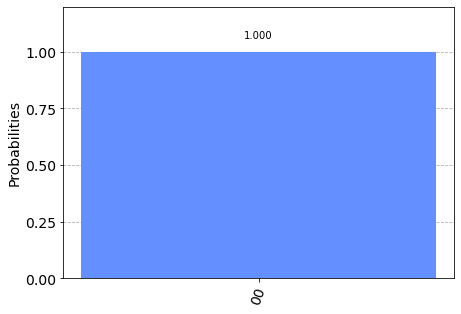

In [27]:
counts = execute(qc_ha,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

<b>Results : </b>
```
0+0 = 00 
0+1 = 01 
1+0 = 01 
1+1 = 00 
```
We are halfway to a fully working half adder - the right bit is done. Now we need to work with the left bit of the output (it will be on qubit 4).

There is only one case for which this bit is ```1``` : ```1+1```=```10```. It happens only when both the bits we are adding are ```1```. So, when both of the inputs are ```1```, we perform a NOT operation on qubit 4 to flip it to ```1```. For this we shall use a *Toffoli* gate (it represents an AND operation).

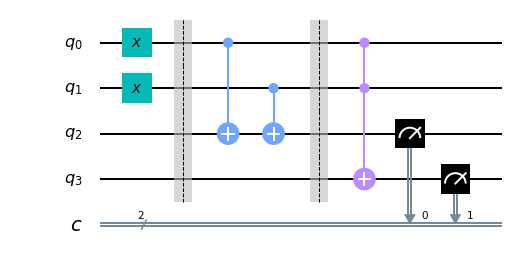

In [38]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in qubits 0 and 1
qc_ha.x(0) # For a=0, remove the this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove the this line. For b=1, leave it.
qc_ha.barrier()
# use cnots to write the XOR of the inputs on qubit 2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
qc_ha.barrier()
# use ccx to write the AND of the inputs on qubit 3
qc_ha.ccx(0,1,3)
# extract outputs
qc_ha.measure(2,0) # for XOR
qc_ha.measure(3,1) # for AND

qc_ha.draw(output='mpl')

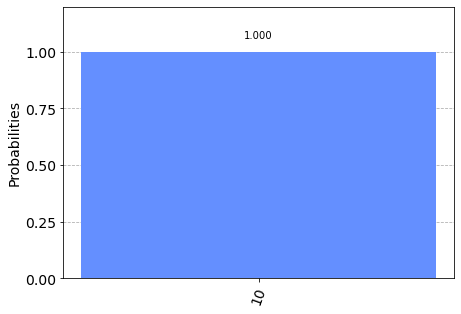

In [39]:
counts = execute(qc_ha,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

<b>Results : </b>
```
0+0 = 00 
0+1 = 01 
1+0 = 01 
1+1 = 10 
```

This circuit in QC that can solve the mathematical problem of 2 qubits addition.